<a href="https://colab.research.google.com/github/messi10tom/RNN-from-scratch/blob/main/RNN_from_scratch.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
data = """During the advent of modern scientific method in the last several centuries, nature became the passive reality, organized and moved by divine laws.[3][4] With the Industrial Revolution, nature increasingly became seen as the part of reality deprived from intentional intervention: it was hence considered as sacred by some traditions (Rousseau, American transcendentalism) or a mere decorum for divine providence or human history (Hegel, Marx). However, a vitalist vision of nature, closer to the pre-Socratic one, got reborn at the same time, especially after Charles Darwin. Within the various uses of the word today, "nature" often refers to geology and wildlife. Nature can refer to the general realm of living plants and animals, and in some cases to the processes associated with inanimate objects—the way that particular types of things exist and change of their own accord, such as the weather and geology of the Earth. It is often taken to mean the "natural environment" or wilderness—wild animals, rocks, forest, and in general those things that have not been substantially altered by human intervention, or which persist despite human intervention. For example, manufactured objects and human interaction generally are not considered part of nature, unless qualified as, for example, "human nature" or "the whole of nature". This more traditional concept of natural things that can still be found today implies a distinction between the natural and the artificial, with the artificial being understood as that which has been brought into being by a human consciousness or a human mind. Depending on the particular context, the term "natural" might also be distinguished from the unnatural or the supernatural."""

In [4]:
data = ''.join([i for i in data.lower() if i.isalpha() or i in [' ', '.']])

In [149]:
import numpy as np

vocab = list(set(data))
X_train = [vocab.index(i) for i in data]
Xtr = np.zeros((len(vocab), len(X_train)))
Xtr[X_train, np.arange(len(X_train))] = 1
#Xtr = np.expand_dims(Xtr, axis=-1)

In [ ]:
np.random.seed(45)
lr = 0.1

Wc = np.random.randn(100, len(vocab))
Uc = np.random.randn(100, 100)
Bc = np.random.randn(100, 1)
Ctm1 = np.zeros((100, 1))
V = np.random.randn(100, 100)

W = np.random.randn(len(vocab), 100)
B = np.random.randn(len(vocab), 1)

Softmax = lambda a: np.exp(a) / np.sum(np.exp(a))

Lt = 0
dYhat_t = np.zeros((len(vocab), 1))
dYbar_t = np.zeros((len(vocab), 1))
dH = np.zeros_like(Ctm1)
dV = np.zeros_like(V)
dC = np.zeros_like(Ctm1)
dCt_dWc = np.zeros((100, len(vocab)))
dCt_dUc = np.zeros((100, 100))
outRNN = np.zeros((len(Xtr), 100, 1))

for i in range(1):
    for t in range(1, len(Xtr)):

        Ct      = np.tanh(Wc @ Xtr[t-1] + Uc @ Ctm1 + Bc)
        Ht      = np.tanh(V @ Ct)
        Ybar_t  = W @ Ht + B
        Yhat_t  = Softmax(Ybar_t)

        outRNN[t-1] = Ht
        Lt += -np.sum((Xtr[t] * np.log(Yhat_t)))

        dYhat_t         = -Xtr[t]/Yhat_t
        dYhat_t_dYbar_t = Yhat_t * (1 - Yhat_t)
        dYbar_t         = dYhat_t * dYhat_t_dYbar_t
        dW              = dYbar_t @ Ht.T
        dB              = dYbar_t
        dH              = W.T @ dYbar_t
        dH_dV           = np.ones_like(V) * ((1 - Ht**2) * Ct).T
        dV              = dH * dH_dV
        dC              = V @ (1 - Ht ** 2)
        dCt_dWc         = (1 - Ct ** 2) @ Xtr[t-1].T + ((1 - Ct ** 2) * Uc) @ dCt_dWc
        dCt_dUc         = (1 - Ct ** 2) @ Ctm1.T + ((1 - Ct ** 2) * Uc) @ dCt_dUc

        dWc             = dC * dCt_dWc
        dUc             = dC * dCt_dUc
        dBc             = dC * (1 - Ct**2)

        # Gradient descent
        Wc = Wc - lr * dWc
        Uc = Uc - lr * dUc
        Bc = Bc - lr * dBc
        V  = V  - lr * dV
        W  = W  - lr * dW
        B  = B  - lr * dB


        Ctm1 = Ct
        

    print(f'loss: {Lt}')

In [213]:
np.random.seed(45)
lr = 0.1
n_hidden = 100
Wc = np.random.randn(n_hidden, len(vocab)) * 5/(3 * n_hidden ** 0.5) 
Uc = np.random.randn(n_hidden, n_hidden) * 5/(3 * n_hidden ** 0.5) 
Bc = np.zeros((n_hidden, 1))
V = np.random.randn(n_hidden, n_hidden) * 5/(3 * n_hidden ** 0.5)

W = np.random.randn(len(vocab), n_hidden) * 5/(3 * len(vocab) ** 0.5)
B = np.zeros((len(vocab), 1))

Softmax = lambda a: np.exp(a) / np.sum(np.exp(a), axis=0)

dYhat_t = np.zeros((len(vocab), 1))
dYbar_t = np.zeros((len(vocab), 1))
dH = np.zeros((n_hidden, 1))
dV = np.zeros_like(V)
dC = np.zeros((n_hidden, 1))
dC_dWc = np.zeros((len(data) - 1, n_hidden, len(vocab)))
dC_dUc = np.zeros((len(data) - 1, n_hidden, n_hidden))
H = np.zeros((n_hidden, len(data) - 1, 1))
C = np.zeros((n_hidden, len(data), 1))

for i in range(1):
    for t in range(1, len(data)):
        Yt, Ctm1 = Xtr[:, t], C[:, t-1]
        Xt = np.expand_dims(Xtr[:, t-1], axis=-1)
        Ct      = np.tanh(Wc @ Xt + Uc @ Ctm1 + Bc)
        Ht      = np.tanh(V @ Ct)
        Ybar_t  = W @ Ht + B
        Yhat_t  = Softmax(Ybar_t)

        H[:, t-1] = Ht
        C[:, t] = Ct

    H     = H.squeeze()
    Ybar  = W @ H + B
    Yhat  = Softmax(Ybar)
    Y     = Xtr[:, 1:].squeeze()

    loss = -np.sum((Y * np.log(Yhat_t)), axis=0)
    
########## BACK PROPAGATION ###########

    C = C.squeeze()
    dYbar = Yhat - Y
    dW = dYbar @ H.T
    dB = dYbar.sum(axis=1, keepdims=True)
    dH = W.T @ dYbar
    dV = (dH * (1 - H**2)) @ C[:, 1:].T
    dC = ((dH * (1 - H**2)).T @ V).T
    dpC_dWc = np.expand_dims((1 - C[:, 1:].T ** 2), axis=-1) @ np.expand_dims(Xtr[:, 1:].T, axis=1)
    dC_dWc = dpC_dWc + (np.stack([(1 - C[:, 1:].T ** 2)] * n_hidden, axis=2) * Uc) @ dC_dWc
    dpC_dUc = np.expand_dims((1 - C[:, 1:].T ** 2), axis=-1) @ np.expand_dims((1 - C[:, 1:].T ** 2), axis=1)
    dC_dUc = dpC_dUc + (np.stack([(1 - C[:, 1:].T ** 2)] * n_hidden, axis=2) * Uc) @ dC_dUc
    
    dWc = dC * dC_dWc
    dUc = dC * dC_dUc
    dBc = dC * (1 - C**2)

#######################################
    print(loss.mean())


KeyboardInterrupt: 

In [212]:
dCt_dWc.shape

(100, 28)

In [202]:
np.expand_dims((1 - C[:, 1:].T ** 2), axis=1).shape

(1673, 1, 100)

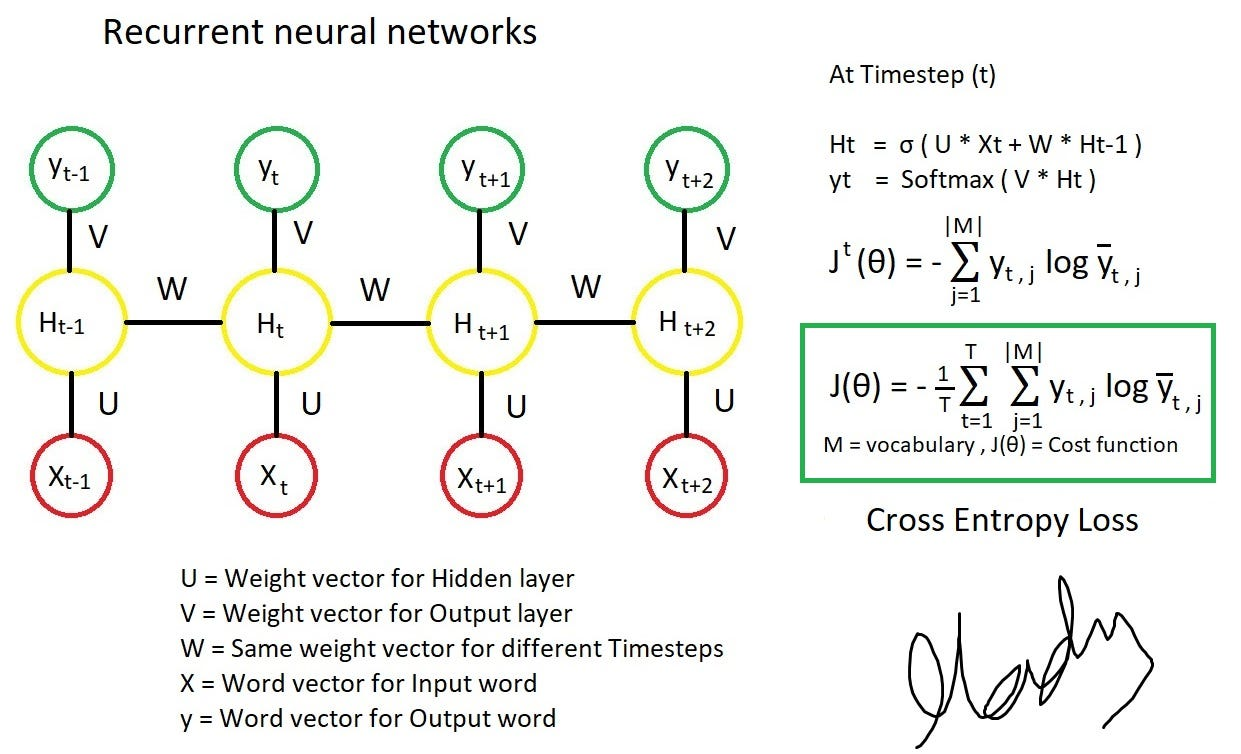